<a href="https://colab.research.google.com/github/WojciechMojsiejuk/GlaucomaDetection/blob/main/glaucoma_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Nov 26 05:11:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/MachineLearning/

/content/gdrive/MyDrive/MachineLearning


In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/MachineLearning/'

In [ ]:
import kaggle

In [ ]:
!kaggle datasets download -d sshikamaru/glaucoma-detection

 97% 390M/402M [00:02<00:00, 140MB/s]
100% 402M/402M [00:03<00:00, 140MB/s]


In [ ]:
!ls

glaucoma-detection.zip	glaucoma_recognition.ipynb  kaggle.json


In [ ]:
# unzip
import zipfile, os

path_to_zip = '/content/gdrive/MyDrive/MachineLearning/glaucoma-detection.zip'
dst_path = '/content/gdrive/MyDrive/MachineLearning/dataset'

if not os.path.exists(dst_path):
  os.makedirs(dst_path)
  with zipfile.ZipFile(path_to_zip, 'r') as file:
    file.extractall(dst_path)

In [ ]:
data_path = os.path.join(dst_path,'Fundus_Train_Val_Data/Fundus_Scanes_Sorted')

In [ ]:
train_path = os.path.join(data_path, 'Train')
validation_path = os.path.join(data_path, 'Validation')

In [ ]:
random_seed = 10

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


train_data = image_dataset_from_directory(train_path,
                                          image_size=(128,128),
                                          batch_size=20,
                                          crop_to_aspect_ratio=True,
                                          seed=random_seed,
                                          validation_split=0.1925,
                                          subset="training",
                                          label_mode='binary')

validation_data = image_dataset_from_directory(train_path,
                                              image_size=(128,128),
                                              batch_size=20,
                                              crop_to_aspect_ratio=True,
                                              seed=random_seed,
                                              validation_split=0.1925,
                                              subset="validation",
                                              label_mode='binary')

test_data = image_dataset_from_directory(validation_path,
                                        image_size=(128,128),
                                        batch_size=20,
                                        crop_to_aspect_ratio=True,
                                        label_mode='binary')


Found 520 files belonging to 2 classes.
Using 420 files for training.
Found 520 files belonging to 2 classes.
Using 100 files for validation.
Found 130 files belonging to 2 classes.


data batch shape: (20, 128, 128, 3)
labels batch shape: (20, 1)
image max value: 255.0


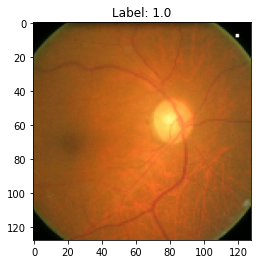

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.strings import as_string
import numpy as np
for x, y in train_data.take(1):
  print('data batch shape:', x.shape)
  print('labels batch shape:', y.shape)
  print('image max value:',np.max(x[0]))
  plt.title(f'Label: {y[0,0].numpy()}')
  plt.imshow(image.array_to_img(x[0]))
  break

We can see that the Image is typical 8 bit RGB image, that is the pixel values range from 0 to 255. For CNN model it is better to normalize the dataset to values from 0 to 1.

In [ ]:
from tensorflow.keras.applications import Xception
conv_base = Xception(weights='imagenet', # randomly initialized parameters
                  include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3))) # Rescaling
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 

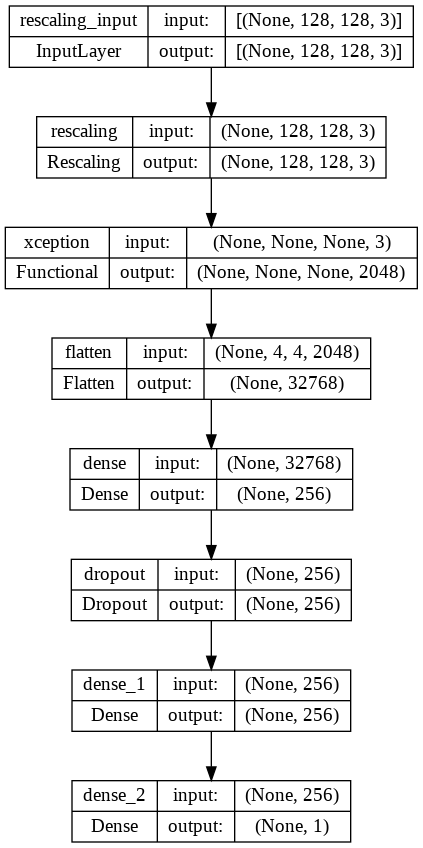

In [ ]:
from tensorflow.keras import utils
dot_img_file = '/content/gdrive/MyDrive/MachineLearning/model_1.png'
utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-7,), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# save best epoch before it starts to overfit
modelckpt = ModelCheckpoint(
    monitor = 'val_acc',
    save_best_only=True,
    filepath=os.path.join(data_path, 'best_model.h5'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=21,
                    epochs=30,
                    validation_data=validation_data,
                    validation_steps=5,
                    callbacks=[modelckpt])

Epoch 1/30
21/21 [==============================] - 23s 727ms/step - loss: 0.8028 - acc: 0.2667 - val_loss: 0.7522 - val_acc: 0.3500
Epoch 2/30
21/21 [==============================] - 17s 605ms/step - loss: 0.7574 - acc: 0.3381 - val_loss: 0.7299 - val_acc: 0.3800
Epoch 3/30
21/21 [==============================] - 20s 748ms/step - loss: 0.7137 - acc: 0.4857 - val_loss: 0.7083 - val_acc: 0.4400
Epoch 4/30
21/21 [==============================] - 16s 600ms/step - loss: 0.6676 - acc: 0.5905 - val_loss: 0.6879 - val_acc: 0.5300
Epoch 5/30
21/21 [==============================] - 19s 718ms/step - loss: 0.6301 - acc: 0.7048 - val_loss: 0.6688 - val_acc: 0.6200
Epoch 6/30
21/21 [==============================] - 17s 606ms/step - loss: 0.5921 - acc: 0.7881 - val_loss: 0.6506 - val_acc: 0.6500
Epoch 7/30
21/21 [==============================] - 17s 603ms/step - loss: 0.5701 - acc: 0.8000 - val_loss: 0.6336 - val_acc: 0.6600
Epoch 8/30
21/21 [==============================] - 19s 749ms/step - 

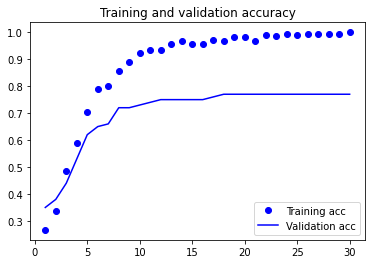

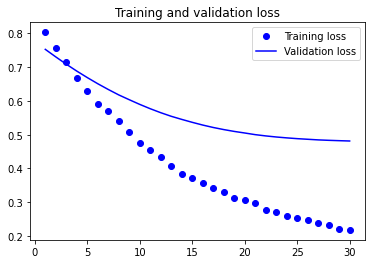

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# Learning from pre-learned model

In [ ]:
from tensorflow.keras import models
model = models.load_model(os.path.join(data_path, 'best_model.h5'))

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-4,), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=21,
                    epochs=10,
                    validation_data=validation_data,
                    validation_steps=5)

Epoch 1/10
21/21 [==============================] - 20s 531ms/step - loss: 0.0791 - acc: 0.9881 - val_loss: 7.9718 - val_acc: 0.7900
Epoch 2/10
21/21 [==============================] - 15s 513ms/step - loss: 0.1172 - acc: 0.9738 - val_loss: 6.7027 - val_acc: 0.7700
Epoch 3/10
21/21 [==============================] - 14s 489ms/step - loss: 0.1277 - acc: 0.9714 - val_loss: 2.6825 - val_acc: 0.7800
Epoch 4/10
21/21 [==============================] - 14s 494ms/step - loss: 0.0328 - acc: 0.9952 - val_loss: 6.6672 - val_acc: 0.7900
Epoch 5/10
21/21 [==============================] - 14s 492ms/step - loss: 0.0375 - acc: 0.9786 - val_loss: 4.9699 - val_acc: 0.8000
Epoch 6/10
21/21 [==============================] - 14s 496ms/step - loss: 0.0295 - acc: 0.9905 - val_loss: 3.9759 - val_acc: 0.7800
Epoch 7/10
21/21 [==============================] - 15s 501ms/step - loss: 0.0222 - acc: 0.9976 - val_loss: 3.5423 - val_acc: 0.7800
Epoch 8/10
21/21 [==============================] - 15s 536ms/step - 

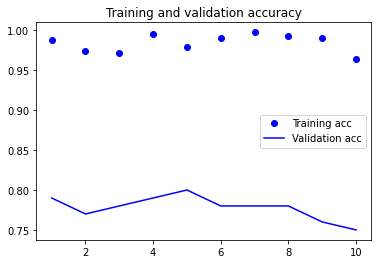

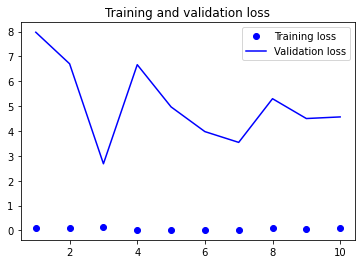

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# Model with frozen weights


In [ ]:
from tensorflow.keras.applications import Xception
conv_base = Xception(weights='imagenet', # randomly initialized parameters
                  include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
conv_base.trainable = False

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3))) # Rescaling
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-7,), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# save best epoch before it starts to overfit
modelckpt = ModelCheckpoint(
    monitor = 'val_acc',
    save_best_only=True,
    filepath=os.path.join(data_path, 'best_model_freeze.h5'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=21,
                    epochs=30,
                    validation_data=validation_data,
                    validation_steps=5,
                    callbacks=[modelckpt])

Epoch 1/30
21/21 [==============================] - 81s 2s/step - loss: 0.9618 - acc: 0.2595 - val_loss: 0.8956 - val_acc: 0.2400
Epoch 2/30
21/21 [==============================] - 14s 497ms/step - loss: 0.8709 - acc: 0.3000 - val_loss: 0.8207 - val_acc: 0.2600
Epoch 3/30
21/21 [==============================] - 14s 475ms/step - loss: 0.8036 - acc: 0.3286 - val_loss: 0.7591 - val_acc: 0.3100
Epoch 4/30
21/21 [==============================] - 14s 476ms/step - loss: 0.7474 - acc: 0.4071 - val_loss: 0.7085 - val_acc: 0.5000
Epoch 5/30
21/21 [==============================] - 14s 482ms/step - loss: 0.7075 - acc: 0.4857 - val_loss: 0.6665 - val_acc: 0.6500
Epoch 6/30
21/21 [==============================] - 14s 478ms/step - loss: 0.6702 - acc: 0.5976 - val_loss: 0.6358 - val_acc: 0.6800
Epoch 7/30
21/21 [==============================] - 14s 480ms/step - loss: 0.6446 - acc: 0.6667 - val_loss: 0.6110 - val_acc: 0.7200
Epoch 8/30
21/21 [==============================] - 14s 472ms/step - los

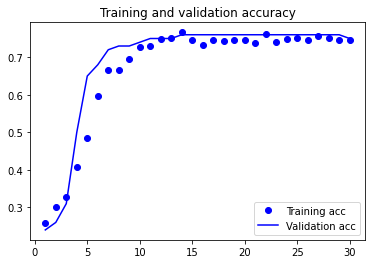

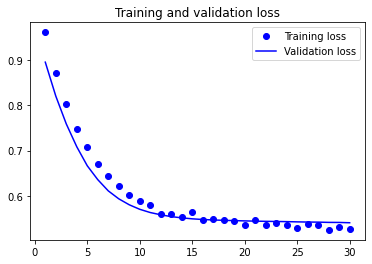

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()


# Model with larger input photos

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


train_data = image_dataset_from_directory(train_path,
                                          image_size=(256,256),
                                          batch_size=20,
                                          crop_to_aspect_ratio=True,
                                          seed=random_seed,
                                          validation_split=0.1925,
                                          subset="training",
                                          label_mode='binary')

validation_data = image_dataset_from_directory(train_path,
                                              image_size=(256,256),
                                              batch_size=20,
                                              crop_to_aspect_ratio=True,
                                              seed=random_seed,
                                              validation_split=0.1925,
                                              subset="validation",
                                              label_mode='binary')

test_data = image_dataset_from_directory(validation_path,
                                        image_size=(256,256),
                                        batch_size=20,
                                        crop_to_aspect_ratio=True,
                                        label_mode='binary')


Found 520 files belonging to 2 classes.
Using 420 files for training.
Found 520 files belonging to 2 classes.
Using 100 files for validation.
Found 130 files belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import Xception
conv_base = Xception(weights='imagenet', # randomly initialized parameters
                  include_top=False)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(256, 256, 3))) # Rescaling
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-4,), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_9 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=21,
                    epochs=30,
                    validation_data=validation_data,
                    validation_steps=5)

Epoch 1/30
21/21 [==============================] - 25s 795ms/step - loss: 0.6518 - acc: 0.7143 - val_loss: 0.8944 - val_acc: 0.7700
Epoch 2/30
21/21 [==============================] - 20s 766ms/step - loss: 0.5879 - acc: 0.7405 - val_loss: 1.0816 - val_acc: 0.7500
Epoch 3/30
21/21 [==============================] - 20s 763ms/step - loss: 0.4496 - acc: 0.7881 - val_loss: 0.7138 - val_acc: 0.7900
Epoch 4/30
21/21 [==============================] - 20s 757ms/step - loss: 0.2307 - acc: 0.8905 - val_loss: 1.1988 - val_acc: 0.7600
Epoch 5/30
21/21 [==============================] - 20s 755ms/step - loss: 0.1819 - acc: 0.9548 - val_loss: 1.3812 - val_acc: 0.7700
Epoch 6/30
21/21 [==============================] - 20s 755ms/step - loss: 0.1029 - acc: 0.9548 - val_loss: 0.8921 - val_acc: 0.7900
Epoch 7/30
21/21 [==============================] - 20s 773ms/step - loss: 0.0802 - acc: 0.9667 - val_loss: 1.1661 - val_acc: 0.7600
Epoch 8/30
21/21 [==============================] - 20s 758ms/step - 

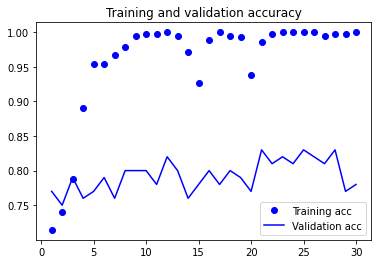

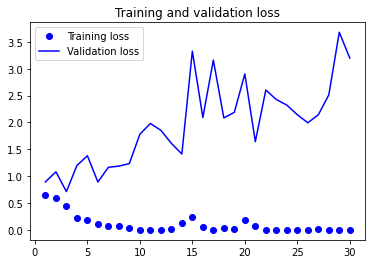

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# Model with preprocessing (obtaining optic disc region of interest from image)

It can be seen that the model is overfitting (memorizing old information) rather than searches for the new patterns. Task is very difficult, we don't classify two separate classes (dogs vs cats), but all of the images present eyes, some of which have glaucoma. When it comes to the glaucoma usually it is mostly noticeable in the optic disc of the eye, let's then focus on this area of an eye

In [ ]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
img_path = '/content/gdrive/MyDrive/MachineLearning/dataset/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative'

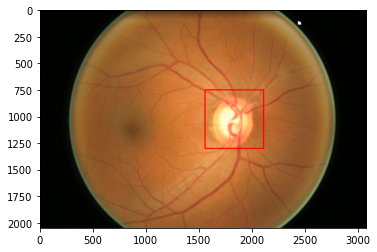

In [ ]:
i_p = os.path.join(img_path,'001.jpg')
img = cv.imread(i_p)[:,:,::-1]
im = img.copy()
cv.rectangle(im,(1550,750),(2100,1300), 255, 10)
plt.imshow(im)

In [ ]:
import numpy as np
from PIL import Image

def crop_circle(img):
  if img.dtype!=np.uint8: # numpy from keras
    img = img.astype(np.uint8)
    img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  else: #opencv
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  width,height = img.shape[:2]

  # define circles https://stackoverflow.com/questions/44588279/find-and-draw-the-largest-contour-in-opencv-on-a-specific-color-python
  xc = height // 2
  yc = width // 2
  radius = int(0.65 * xc)

  # draw filled circles in white on black background as masks
  mask1 = np.zeros_like(img).astype(np.uint8)
  mask1 = cv.circle(mask1, (xc,yc), radius, (255,255,255), -1)
  img = np.array(img).astype(np.uint8)
  return np.bitwise_and(img, mask1)
  
def optic_disc_crop(img, draw=False, pad=10):
  blur = cv.GaussianBlur(img,(5,5),0)
  ret,th = cv.threshold(blur,180,255,cv.THRESH_BINARY) # simple threshold
  contours, hierarchy = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
  if len(contours) != 0:
      # find the biggest countour by the area
      c = max(contours, key = cv.contourArea)
      x,y,w,h = cv.boundingRect(c)

      # draw the biggest contour
      if draw:
        cv.rectangle(img,(x,y),(x+w,y+h),255,10)
        return img
      else:
        try:
          cropped_img = img[y-pad:y+h+pad, x-pad:x+w+pad]
        except IndexError:
          try:
            cropped_img = img[y:y+h, x:x+w]
          except IndexError:
            cropped_img = img
        return cropped_img

In [ ]:
def resize_and_color(img):
  if img.dtype!=np.uint8:
    img = img.astype(np.uint8)
  img = cv.cvtColor(img,cv.COLOR_GRAY2RGB)
  img = cv.resize(img, (1024, 1024))
  return img

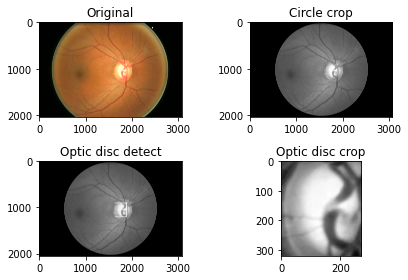

In [ ]:
plt.subplot(2,2,1)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.subplot(2,2,2)
plt.title('Circle crop')
cropped = crop_circle(img)
plt.imshow(cropped, cmap='gray')
plt.subplot(2,2,3)
plt.title('Optic disc detect')
detect = optic_disc_crop(cropped.copy(), True)
plt.imshow(detect, cmap='gray')
plt.subplot(2,2,4)
plt.title('Optic disc crop')
cropped = optic_disc_crop(cropped)
plt.imshow(cropped, cmap='gray')
plt.tight_layout()

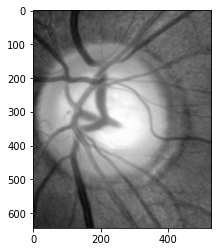

In [ ]:
i_p = os.path.join(img_path,'005.jpg')
img = cv.imread(i_p)
cropped = crop_circle(img)
cropped = optic_disc_crop(cropped)
plt.imshow(cropped, cmap='gray')

In [ ]:
img_path = '/content/gdrive/MyDrive/MachineLearning/dataset/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Positive'

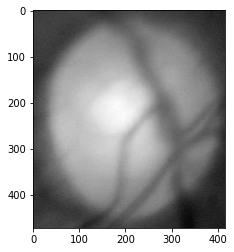

In [ ]:
i_p = os.path.join(img_path,'036.jpg')
img = cv.imread(i_p)
cropped = crop_circle(img)
cropped = optic_disc_crop(cropped, False)
plt.imshow(cropped, cmap='gray')

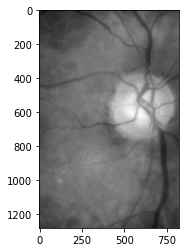

In [ ]:
i_p = os.path.join(img_path,'072.jpg')
img = cv.imread(i_p)
cropped = crop_circle(img)
cropped = optic_disc_crop(cropped)
plt.imshow(cropped, cmap='gray')

After writting optic disc extractor which works both on healthy eyes and eyes with glaucoma we can attach this function to our preprocessing pipeline

In [ ]:
def preprocessing_pipeline(img):
  return resize_and_color(optic_disc_crop(crop_circle(img)))

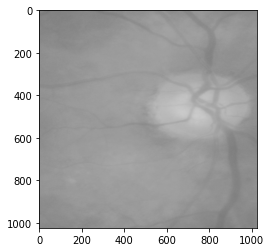

In [ ]:
i_p = os.path.join(img_path,'072.jpg')
img = cv.imread(i_p)
plt.imshow(preprocessing_pipeline(img), cmap='gray')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_gen = ImageDataGenerator(
    preprocessing_function=preprocessing_pipeline,
    validation_split=0.1941)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocessing_pipeline)

train_data = train_gen.flow_from_directory(
    train_path,
    target_size=(1024, 1024),
    class_mode='binary',
    batch_size=20,
    seed=random_seed,
    subset="training",
    keep_aspect_ratio=True
)

validation_data = train_gen.flow_from_directory(
    train_path,
    target_size=(1024, 1024),
    class_mode='binary',
    batch_size=20,
    seed=random_seed,
    subset="validation",
    keep_aspect_ratio=True
    )

test_data = test_gen.flow_from_directory(
    validation_path,
    target_size=(1024, 1024),
    batch_size=20,
    keep_aspect_ratio=True
    )

Found 420 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import Xception
conv_base = Xception(weights='imagenet', # randomly initialized parameters
                  include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
conv_base.trainable = False

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3))) # Rescaling
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-5,), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# save best epoch before it starts to overfit
modelckpt = ModelCheckpoint(
    monitor = 'val_acc',
    save_best_only=True,
    filepath=os.path.join(data_path, 'best_model_optic.h5'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=21,
                    epochs=30,
                    validation_data=validation_data,
                    validation_steps=5,
                    callbacks=[modelckpt])

Epoch 1/30


InvalidArgumentError: ignored

# Feature extraction

In [ ]:
from glob import glob

In [ ]:
import os

dst_path = '/content/gdrive/MyDrive/MachineLearning/modified_dataset'
train_positive_path = os.path.join(dst_path, 'Train/Glaucoma_Positive')
test_positive_path = os.path.join(dst_path, 'Test/Glaucoma_Positive')
train_negative_path = os.path.join(dst_path, 'Train/Glaucoma_Negative')
test_negative_path = os.path.join(dst_path, 'Test/Glaucoma_Negative')



if not os.path.exists(dst_path):
  os.makedirs(dst_path)
if not os.path.exists(train_positive_path):
  os.makedirs(train_positive_path)

if not os.path.exists(test_positive_path):
  os.makedirs(test_positive_path)

if not os.path.exists(train_negative_path):
  os.makedirs(train_negative_path)

if not os.path.exists(test_negative_path):
  os.makedirs(test_negative_path)

In [ ]:
import numpy as np
from PIL import Image
import cv2 as cv

def white_balance(img):
    result = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv.cvtColor(result, cv.COLOR_LAB2BGR)
    return result


def crop_circle(img):
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  
  width,height = img.shape[:2]

  # define circles https://stackoverflow.com/questions/44588279/find-and-draw-the-largest-contour-in-opencv-on-a-specific-color-python
  xc = height // 2
  yc = width // 2
  radius = int(0.65 * xc)

  # draw filled circles in white on black background as masks
  mask1 = np.zeros_like(img).astype(np.uint8)
  mask1 = cv.circle(mask1, (xc,yc), radius, (255,255,255), -1)
  img = np.array(img).astype(np.uint8)
  return np.bitwise_and(img, mask1)
  
def optic_disc_crop(img, color_img, draw=False, pad=10):
  blur = cv.GaussianBlur(img,(5,5),0)
  ret,th = cv.threshold(blur,150,255,cv.THRESH_BINARY) # simple threshold
  contours, hierarchy = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
  if len(contours) != 0:
      # find the biggest countour by the area
      c = max(contours, key = cv.contourArea)
      x,y,w,h = cv.boundingRect(c)

      # draw the biggest contour
      if draw:
        cv.rectangle(color_img,(x,y),(x+w,y+h),255,10)
        return img
      else:
        try:
          cropped_img = color_img[y-pad:y+h+pad, x-pad:x+w+pad]
        except IndexError:
          try:
            cropped_img = color_img[y:y+h, x:x+w]
          except IndexError:
            cropped_img = color_img
        finally:
          return cropped_img
  else:
    return color_img

In [ ]:
img_path = '/content/gdrive/MyDrive/MachineLearning/dataset/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive'
# img_path = '/content/gdrive/MyDrive/MachineLearning/dataset/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative'

In [ ]:
img_files = glob(os.path.join(img_path, '*.jpg'))

In [ ]:
import warnings
from google.colab.patches import cv2_imshow

for img_file in img_files:
  img = cv.imread(img_file)
  if img is None:
    warnings.warn('Could not load a file')
    continue
  img = img.astype(np.uint8)
  wb_img = white_balance(img)
  circle_img = crop_circle(img)
  cropped = optic_disc_crop(circle_img, wb_img)
  img_name = os.path.basename(img_file)
  cv.imwrite(os.path.join(test_positive_path, img_name), cropped)

# Cropped images model

In [ ]:
train_path = os.path.join(dst_path,'Train')
test_path = os.path.join(dst_path,'Test')

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


train_data = image_dataset_from_directory(train_path,
                                          image_size=(400, 400),
                                          batch_size=20,
                                          crop_to_aspect_ratio=True,
                                          seed=random_seed,
                                          validation_split=0.1925,
                                          subset="training",
                                          label_mode='binary')

validation_data = image_dataset_from_directory(train_path,
                                              image_size=(400,400),
                                              batch_size=20,
                                              crop_to_aspect_ratio=True,
                                              seed=random_seed,
                                              validation_split=0.1925,
                                              subset="validation",
                                              label_mode='binary')

test_data = image_dataset_from_directory(test_path,
                                        image_size=(400,400),
                                        batch_size=20,
                                        crop_to_aspect_ratio=True,
                                        label_mode='binary')

Found 520 files belonging to 2 classes.
Using 420 files for training.
Found 520 files belonging to 2 classes.
Using 100 files for validation.
Found 130 files belonging to 2 classes.


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(400, 400, 3))) # Rescaling
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-5,), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 400, 400, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten_4 (Flatten)         (None, 346112)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               88604928  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 1)                

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=21,
                    epochs=30,
                    validation_data=validation_data,
                    validation_steps=5)

Epoch 1/30
21/21 [==============================] - 37s 1s/step - loss: 0.6672 - acc: 0.6738 - val_loss: 0.6168 - val_acc: 0.7200
Epoch 2/30
21/21 [==============================] - 29s 1s/step - loss: 0.3957 - acc: 0.8238 - val_loss: 0.5704 - val_acc: 0.7300
Epoch 3/30
21/21 [==============================] - 29s 1s/step - loss: 0.1983 - acc: 0.9381 - val_loss: 0.6231 - val_acc: 0.7600
Epoch 4/30
21/21 [==============================] - 30s 1s/step - loss: 0.0756 - acc: 0.9881 - val_loss: 0.7774 - val_acc: 0.7200
Epoch 5/30
21/21 [==============================] - 31s 1s/step - loss: 0.0370 - acc: 1.0000 - val_loss: 0.9891 - val_acc: 0.7100
Epoch 6/30
21/21 [==============================] - 31s 1s/step - loss: 0.0165 - acc: 0.9976 - val_loss: 1.0933 - val_acc: 0.6600
Epoch 7/30
21/21 [==============================] - 31s 1s/step - loss: 0.0083 - acc: 1.0000 - val_loss: 1.1510 - val_acc: 0.6700
Epoch 8/30
21/21 [==============================] - 32s 1s/step - loss: 0.0044 - acc: 1.00

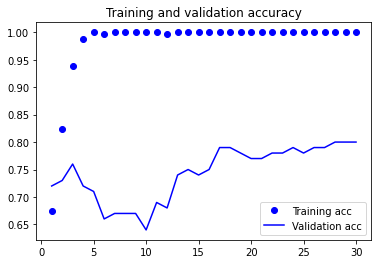

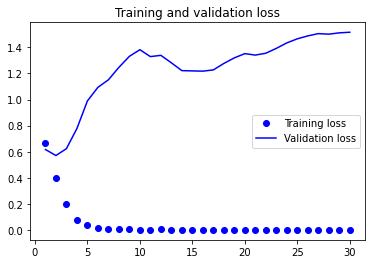

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()